In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf #макроданные
import requests as rq
from pmdarima import auto_arima #автоподбор параметров для ARIMA

from sklearn.metrics import r2_score, mean_squared_error as mse,mean_absolute_percentage_error as mape #метрики

from datetime import datetime, timedelta #операции с типом datetime

import warnings #заглушить предупреждения
warnings.filterwarnings("ignore")

## Выгрузка данных

In [2]:
data=pd.read_csv('collected_data.csv',index_col=0).set_index('date',drop=True).drop('index',axis=1)
data.index=pd.to_datetime(data.index, errors='coerce')
data.drop(columns=['company_number'],inplace=True)
company_names=data.company_name.unique()

## Макроданные

#### Индекс Dow John's и цена на нефть марки Brent

In [3]:
DJI = yf.Ticker("^DJI")
DJI_hist = DJI.history(period="max").drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

brent_oil=yf.Ticker("BZ=F")
hist_oil = brent_oil.history(period="max").drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

In [4]:
#среднее за предыдущий квартал
DJI_hist=DJI_hist.rolling(92).mean().dropna()
hist_oil=hist_oil.rolling(92).mean().dropna()

#### GDP USA

World Bank data:

In [5]:
#имеет только годовые значения, потому бесполезен
import urllib.request
import zipfile
url='https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=csv'
urllib.request.urlretrieve(url, "GDP.zip")
compressed_file = zipfile.ZipFile('GDP.zip')
csv_file = compressed_file.open('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4701247.csv')
GDP = pd.read_csv(csv_file,skiprows=4)
GDP_yearly=GDP[GDP['Country Code']=='USA'].transpose()

Federal Reserve Bank of St. Louis API:

In [6]:
key='f5eaa26b57646b635b160499e66b34be'
api='https://api.stlouisfed.org/fred/series/observations?series_id=GDP&api_key='

In [7]:
a=rq.get(api+key+'&file_type=json&frequency=q').json()
gdp_df=pd.json_normalize(a['observations'])
gdp_df=gdp_df.drop(columns=['realtime_start','realtime_end'])\
            .replace('.',np.NaN).dropna()

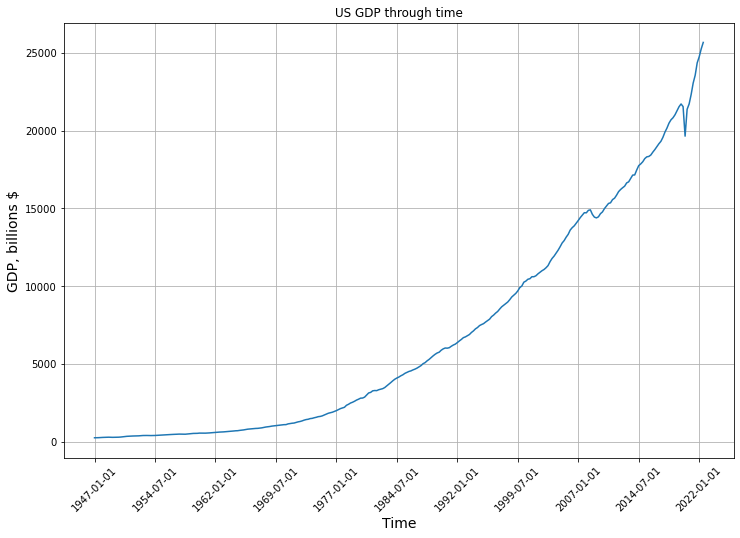

In [8]:
fig, ax=plt.subplots(figsize=(12,8))

ax.plot(gdp_df.date,gdp_df.value.map(float))
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.xaxis.set_tick_params(rotation=45)
ax.set_title('US GDP through time')
ax.set_xlabel('Time',size=14)
ax.set_ylabel('GDP, billions $',size=14)
ax.grid()
plt.show()

In [9]:
gdp_df.index=(pd.to_datetime(gdp_df.date)-timedelta(days=1))

In [10]:
data=data.merge(DJI_hist,left_index=True,right_index=True)\
        .merge(hist_oil,left_index=True,right_index=True)\
        .merge(gdp_df.value.map(float),left_index=True,right_index=True)\
        .rename(columns={'Close_x':'Dow_John_s','Close_y':'Brent_price','value':'US_GDP'})

#### NAICS 211 (Oil and Gas Extraction in the United States)

In [11]:
key='f5eaa26b57646b635b160499e66b34be'
api='https://api.stlouisfed.org/fred/series/observations?series_id=IPG211SQ&api_key='
a=rq.get(api+key+'&file_type=json&frequency=q').json()
NAICS_211_df=pd.json_normalize(a['observations'])
NAICS_211_df=NAICS_211_df.drop(columns=['realtime_start','realtime_end'])\
            .replace('.',np.NaN).dropna()
NAICS_211_df.index=(pd.to_datetime(NAICS_211_df.date)-timedelta(days=1))

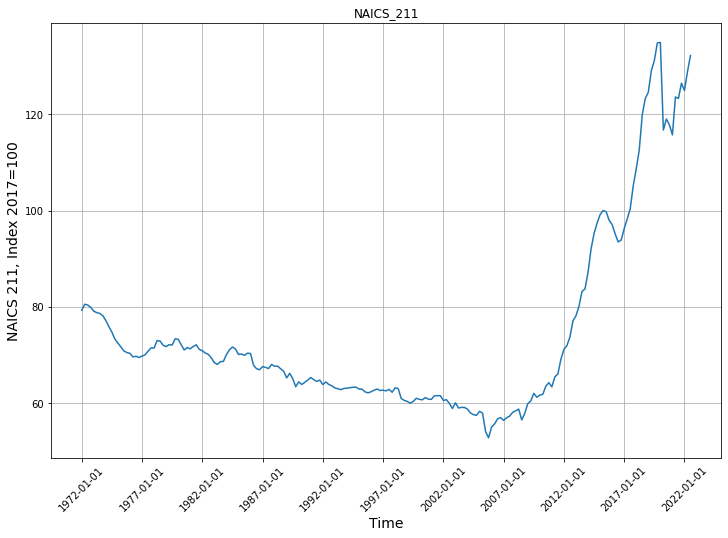

In [12]:
fig, ax=plt.subplots(figsize=(12,8))

ax.plot(NAICS_211_df.date,NAICS_211_df.value.map(float))
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.xaxis.set_tick_params(rotation=45)
ax.set_title('NAICS_211')
ax.set_xlabel('Time',size=14)
ax.set_ylabel('NAICS 211, Index 2017=100',size=14)
ax.grid()
plt.show()

In [13]:
data=data.merge(NAICS_211_df.value.map(float),left_index=True,right_index=True)\
    .rename(columns={'value':'NAICS_211'})

#### Personal Consumption Expenditures (PCEC)

In [14]:
key='f5eaa26b57646b635b160499e66b34be'
api='https://api.stlouisfed.org/fred/series/observations?series_id=PCEC&api_key='
a=rq.get(api+key+'&file_type=json&frequency=q').json()
PCEC_df=pd.json_normalize(a['observations'])
PCEC_df=PCEC_df.drop(columns=['realtime_start','realtime_end'])\
            .replace('.',np.NaN).dropna()
PCEC_df.index=(pd.to_datetime(PCEC_df.date)-timedelta(days=1))

In [15]:
data=data.merge(PCEC_df.value.map(float),left_index=True,right_index=True)\
    .rename(columns={'value':'PCEC'})

####  Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)

In [16]:
key='f5eaa26b57646b635b160499e66b34be'
api='https://api.stlouisfed.org/fred/series/observations?series_id=CPIAUCSL&api_key='
a=rq.get(api+key+'&file_type=json&frequency=q').json()
CPIAUCSL_df=pd.json_normalize(a['observations'])
CPIAUCSL_df=CPIAUCSL_df.drop(columns=['realtime_start','realtime_end'])\
            .replace('.',np.NaN).dropna()
CPIAUCSL_df.index=(pd.to_datetime(CPIAUCSL_df.date)-timedelta(days=1))

In [17]:
data=data.merge(CPIAUCSL_df.value.map(float),left_index=True,right_index=True)\
    .rename(columns={'value':'CPIAUCSL'})

#### Unemployment Rate (UNRATE)	

In [18]:
key='f5eaa26b57646b635b160499e66b34be'
api='https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&api_key='
a=rq.get(api+key+'&file_type=json&frequency=q').json()
UNRATE_df=pd.json_normalize(a['observations'])
UNRATE_df=UNRATE_df.drop(columns=['realtime_start','realtime_end'])\
            .replace('.',np.NaN).dropna()
UNRATE_df.index=(pd.to_datetime(UNRATE_df.date)-timedelta(days=1))

In [19]:
data=data.merge(UNRATE_df.value.map(float),left_index=True,right_index=True)\
    .rename(columns={'value':'UNRATE'})

#### Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB)

In [20]:
key='f5eaa26b57646b635b160499e66b34be'
api='https://api.stlouisfed.org/fred/series/observations?series_id=BOPGSTB&api_key='
a=rq.get(api+key+'&file_type=json&frequency=q').json()
BOPGSTB_df=pd.json_normalize(a['observations'])
BOPGSTB_df=BOPGSTB_df.drop(columns=['realtime_start','realtime_end'])\
            .replace('.',np.NaN).dropna()
BOPGSTB_df.index=(pd.to_datetime(BOPGSTB_df.date)-timedelta(days=1))

In [21]:
data=data.merge(BOPGSTB_df.value.map(float),left_index=True,right_index=True)\
    .rename(columns={'value':'BOPGSTB'})

In [22]:
data[['Dow_John_s','Brent_price','US_GDP','NAICS_211','PCEC','CPIAUCSL','UNRATE','BOPGSTB']].corr().apply(abs)

,Dow_John_s,Brent_price,US_GDP,NAICS_211,PCEC,CPIAUCSL,UNRATE,BOPGSTB
Dow_John_s,1.000000,0.554214,0.971149,0.919020,0.965317,0.988061,0.193663,0.728526
Brent_price,0.554214,1.000000,0.644174,0.591866,0.635591,0.569820,0.308705,0.287777
US_GDP,0.971149,0.644174,1.000000,0.929833,0.997406,0.980577,0.353545,0.680658
NAICS_211,0.919020,0.591866,0.929833,1.000000,0.905363,0.906635,0.365801,0.468740
PCEC,0.965317,0.635591,0.997406,0.905363,1.000000,0.976518,0.361028,0.704676
CPIAUCSL,0.988061,0.569820,0.980577,0.906635,0.976518,1.000000,0.186876,0.745966
UNRATE,0.193663,0.308705,0.353545,0.365801,0.361028,0.186876,1.000000,0.208353
BOPGSTB,0.728526,0.287777,0.680658,0.468740,0.704676,0.745966,0.208353,1.000000


## Построение модели

In [23]:
#здесь лаг - значение через 1,2 или 3 квартала
data_dict={}
for name in company_names:
    df=data.query('company_name==@name')
    data_dict[f'{name}'] = df
    #train[f'{name}'] = df.drop( df[(df.op_in == 0.) | (df.revenue == 0.)].index ) #удаляю строки с нулевыми revenue или op_in
    df['lag_1_op_in']=df.op_in.shift(-1)
    df['lag_2_op_in']=df.op_in.shift(-2)
    df['lag_3_op_in']=df.op_in.shift(-3)
    
    df['lag_1_revenue']=df.revenue.shift(-1)
    df['lag_2_revenue']=df.revenue.shift(-2)
    df['lag_3_revenue']=df.revenue.shift(-3)

### Revenue

#### Первый лаг

In [24]:
df=data_dict['AMPY.xlsx'].lag_1_revenue.dropna()
y_train=df[:-4]
y_test=df[-4:]
y_train.index=pd.to_datetime(y_train.index, errors='coerce')
y_test.index=pd.to_datetime(y_test.index, errors='coerce')

X=data_dict['AMPY.xlsx'].query("lag_1_revenue==lag_1_revenue")\
    [['Brent_price','NAICS_211','PCEC','UNRATE','BOPGSTB']]
#убрал: 'Dow_John_s','US_GDP','CPIAUCSL' - сильно скорелированы

X_train=X[:-4]
X_test=X[-4:]

arima_model=auto_arima(y_train,X=X_train,random_state=0)
y_pred, confint = arima_model.predict(n_periods=4,X=X_test,return_conf_int=True)
cf= pd.DataFrame(confint)
y_pred.index=y_test.index
print('mse:',mse(y_test,y_pred),'\nmape:',mape(y_test,y_pred),'\nR2:',r2_score(y_test,y_pred),sep='\t')

mse:	5737.565672026241	
mape:	1.398132815202811	
R2:	-17.50360039709882


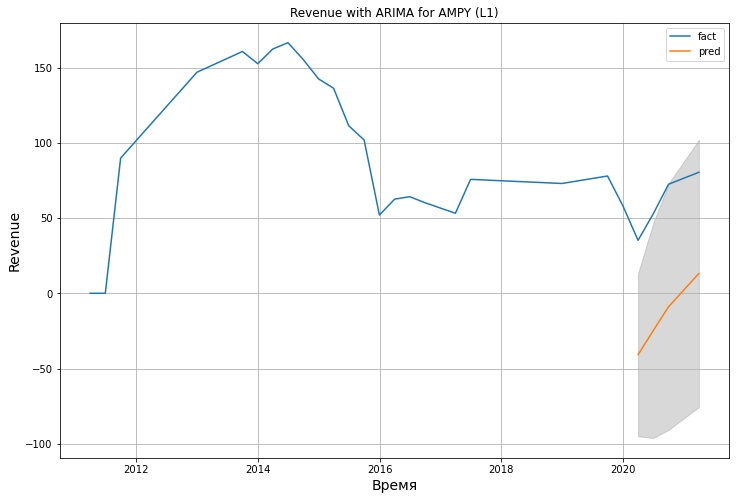

In [25]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot( pd.concat([y_train,y_test]), label='fact')
ax.plot(y_pred, label='pred' )
ax.legend()
ax.fill_between(y_pred.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
ax.set(title='Revenue with ARIMA for AMPY (L1)')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Revenue',size=14)
plt.grid()
plt.show()

#### Второй лаг

In [26]:
df=data_dict['AMPY.xlsx'].lag_2_revenue.dropna()
y_train=df[:-4]
y_test=df[-4:]
y_train.index=pd.to_datetime(y_train.index, errors='coerce')
y_test.index=pd.to_datetime(y_test.index, errors='coerce')
X=data_dict['AMPY.xlsx'].query("lag_2_revenue==lag_2_revenue")\
    [['Brent_price','NAICS_211','PCEC','UNRATE','BOPGSTB']]
#убрал: 'Dow_John_s','US_GDP','CPIAUCSL' - сильно скорелированы
X_train=X[:-4]
X_test=X[-4:]

arima_model=auto_arima(y_train,X=X_train,random_state=0)
y_pred, confint = arima_model.predict(n_periods=4,X=X_test,return_conf_int=True)
cf= pd.DataFrame(confint)
y_pred.index=y_test.index

print('mse:',mse(y_test,y_pred),'\nmape:',mape(y_test,y_pred),'\nR2:',r2_score(y_test,y_pred),sep='\t')

mse:	5869.917187562736	
mape:	1.1841346862334847	
R2:	-17.93043290681245


#### Третий лаг

In [27]:
df=data_dict['AMPY.xlsx'].lag_3_revenue.dropna()
y_train=df[:-4]
y_test=df[-4:]
y_train.index=pd.to_datetime(y_train.index, errors='coerce')
y_test.index=pd.to_datetime(y_test.index, errors='coerce')
X=data_dict['AMPY.xlsx'].query("lag_3_revenue==lag_3_revenue")\
    [['Brent_price','UNRATE','BOPGSTB']]
#убрал: 'Dow_John_s','US_GDP','CPIAUCSL','PCEC','NAICS_211' - сильно скорелированы
X_train=X[:-4]
X_test=X[-4:]

arima_model=auto_arima(y_train,X=X_train,random_state=0)
y_pred, confint = arima_model.predict(n_periods=4,X=X_test,return_conf_int=True)
cf= pd.DataFrame(confint)
y_pred.index=y_test.index

print('mse:',mse(y_test,y_pred),'\nmape:',mape(y_test,y_pred),'\nR2:',r2_score(y_test,y_pred),sep='\t')

mse:	1101.008585234673	
mape:	0.5743515418603082	
R2:	-2.5507433046535994


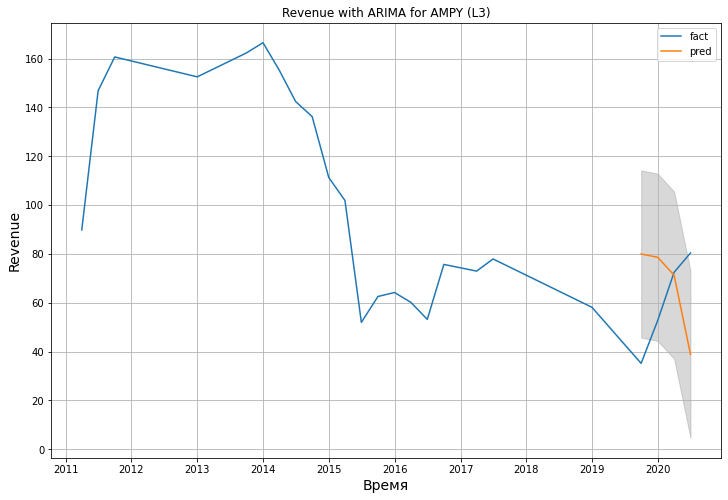

In [28]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot( pd.concat([y_train,y_test]), label='fact')
ax.plot(y_pred, label='pred' )
ax.legend()
ax.fill_between(y_pred.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
ax.set(title='Revenue with ARIMA for AMPY (L3)')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Revenue',size=14)
plt.grid()
plt.show()

In [29]:
arima_model.params()

intercept        0.771436
Brent_price      1.399961
UNRATE           0.531339
BOPGSTB          0.000262
sigma2         305.426138
dtype: float64

Вывод: лучше всего предсказывать на 3 лаге, хотя прогноз показывает нисходящий тренд, что не соответствует реальному тренду

In [30]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                        SARIMAX   Log Likelihood                 -85.578
Date:                Wed, 30 Nov 2022   AIC                            181.156
Time:                        14:17:00   BIC                            186.134
Sample:                             0   HQIC                           182.128
                                 - 20                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.7714     60.167      0.013      0.990    -117.155     118.697
Brent_price     1.4000      0.275      5.097      0.000       0.862       1.938
UNRATE          0.5313      3.198      0.166      0.868      -5.736       6.799
BOPGSTB         0.0003      0.001      0.189      0.850      -0.002       0.003
sigma2        305.4261    169.378      1.803      0.071     -26.549     637.401
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.52
Prob(Q):                              1.00   Prob(JB):                         0.17
Heteroskedasticity (H):               0.64   Skew:                            -1.01
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Из таблицы выше видно, что условие независимости остатков выполняется (отсутствует корреляция), т.к. p-значение теста Льюнга-Бокса выше любого значимого уровня (Prob(Q) ). Таким образом мы не отвергаем нулевую гипотезу о независимости остатков. 

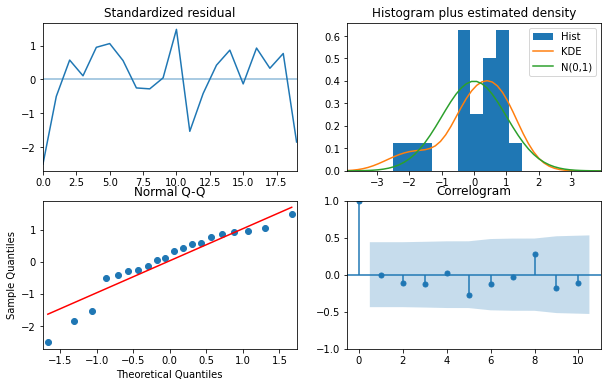

In [31]:
arima_model.plot_diagnostics(figsize=(10,6))
plt.show()

Видно, что коррелограмма не выявляет значимых корреляций в остатках. Из графика квантиль-квантиль видно, что остатки распределены не нормально, однако это не строгое требование для нашей модели

### Operating income

**Первый лаг**

In [32]:
df=data_dict['AMPY.xlsx'].lag_1_op_in.dropna()
y_train=df[:-4]
y_test=df[-4:]
y_train.index=pd.to_datetime(y_train.index, errors='coerce')
y_test.index=pd.to_datetime(y_test.index, errors='coerce')
X=data_dict['AMPY.xlsx'].query("lag_1_op_in==lag_1_op_in")\
    [['Brent_price','NAICS_211','PCEC','UNRATE','BOPGSTB']]
#убрал: 'Dow_John_s','US_GDP','CPIAUCSL' - сильно скорелированы
X_train=X[:-4]
X_test=X[-4:]

arima_model=auto_arima(y_train,X=X_train,random_state=0)
y_pred, confint = arima_model.predict(n_periods=4,X=X_test,return_conf_int=True)
cf= pd.DataFrame(confint)
y_pred.index=y_test.index

print('mse:',mse(y_test,y_pred),'\nmape:',mape(y_test,y_pred),'\nR2:',r2_score(y_test,y_pred),sep='\t')

mse:	488.63057274252753	
mape:	1.2616174991154976	
R2:	0.26713860391787037


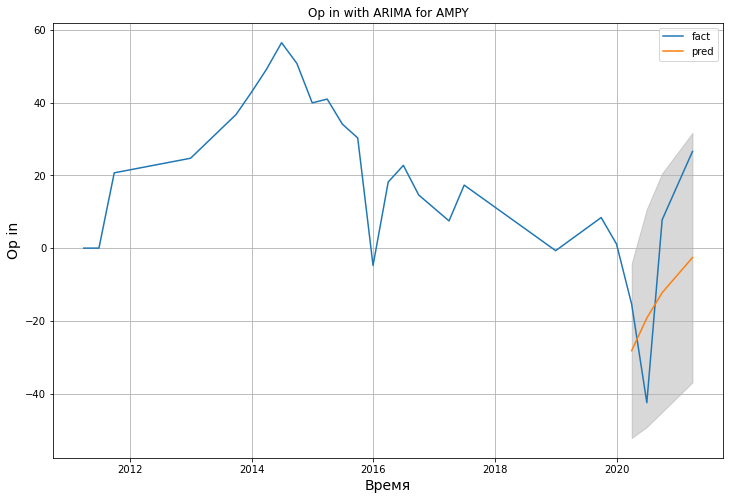

In [33]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot( pd.concat([y_train,y_test]), label='fact')
ax.plot(y_pred, label='pred' )
ax.legend()
ax.fill_between(y_pred.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
ax.set(title='Op in with ARIMA for AMPY')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Op in',size=14)
plt.grid()
plt.show()

In [34]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -85.258
Date:                Wed, 30 Nov 2022   AIC                            184.516
Time:                        14:17:02   BIC                            192.153
Sample:                             0   HQIC                           186.315
                                 - 22                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Brent_price     0.2475      0.413      0.600      0.549      -0.561       1.056
NAICS_211      -0.4571      1.499     -0.305      0.760      -3.396       2.481
PCEC            0.0077      0.014      0.569      0.569      -0.019       0.034
UNRATE         -2.2300     13.644     -0.163      0.870     -28.972      24.512
BOPGSTB         0.0010      0.002      0.558      0.577      -0.002       0.004
ar.L1           0.7465      0.250      2.985      0.003       0.256       1.237
sigma2        149.8066     72.174      2.076      0.038       8.347     291.266
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 1.96
Prob(Q):                              0.48   Prob(JB):                         0.38
Heteroskedasticity (H):               0.40   Skew:                            -0.65
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

У данной модели также выполняется условие независимости остатков (Prob(Q)>0.05 )

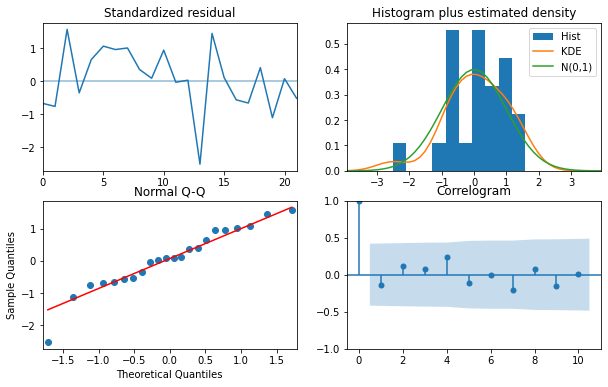

In [35]:
arima_model.plot_diagnostics(figsize=(10,6))
plt.show()

Аналогичная картина: коррелограмма не показывает значимых корреляций в остатках

**Второй лаг**

In [36]:
df=data_dict['AMPY.xlsx'].lag_2_op_in.dropna()
y_train=df[:-4]
y_test=df[-4:]
y_train.index=pd.to_datetime(y_train.index, errors='coerce')
y_test.index=pd.to_datetime(y_test.index, errors='coerce')
X=data_dict['AMPY.xlsx'].query("lag_2_op_in==lag_2_op_in")\
    [['Brent_price','NAICS_211','PCEC','UNRATE','BOPGSTB']]
#убрал: 'Dow_John_s','US_GDP','CPIAUCSL' - сильно скорелированы
X_train=X[:-4]
X_test=X[-4:]

arima_model=auto_arima(y_train,X=X_train,random_state=0)
y_pred, confint = arima_model.predict(n_periods=4,X=X_test,return_conf_int=True)
cf= pd.DataFrame(confint)
y_pred.index=y_test.index

print('mse:',mse(y_test,y_pred),'\nmape:',mape(y_test,y_pred),'\nR2:',r2_score(y_test,y_pred),sep='\t')

mse:	1033.758046910169	
mape:	1.3311179152814319	
R2:	-0.5504583784382284


Вывод: в случае op_in прогноз лучше на первом лаге